### Prueba 1 - Hito 2 - Javier Rojas Benitez - G56

In [13]:
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import funciones_auxiliares_hito_2 as aux

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 10)

importlib.reload(aux)

<module 'funciones_auxiliares_hito_2' from 'c:\\Users\\ppizarro\\Desktop\\Javier Rojas\\Javier\\propio\\personal\\G56\\machine-learning\\prueba\\prueba_1\\hito_2\\funciones_auxiliares_hito_2.py'>

In [14]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")


# Preprocesamiento

## Variables independientes

In [15]:
df["procesados_lema"] = df.content.str.lower().apply(aux.preprocesar_texto_lema)
df["procesados_stem"] = df.content.str.lower().apply(aux.preprocesar_texto_stem)

df_lema = aux.obtener_100_palabras_mas_frecuentes(df["procesados_lema"])
df_stem = aux.obtener_100_palabras_mas_frecuentes(df["procesados_stem"])

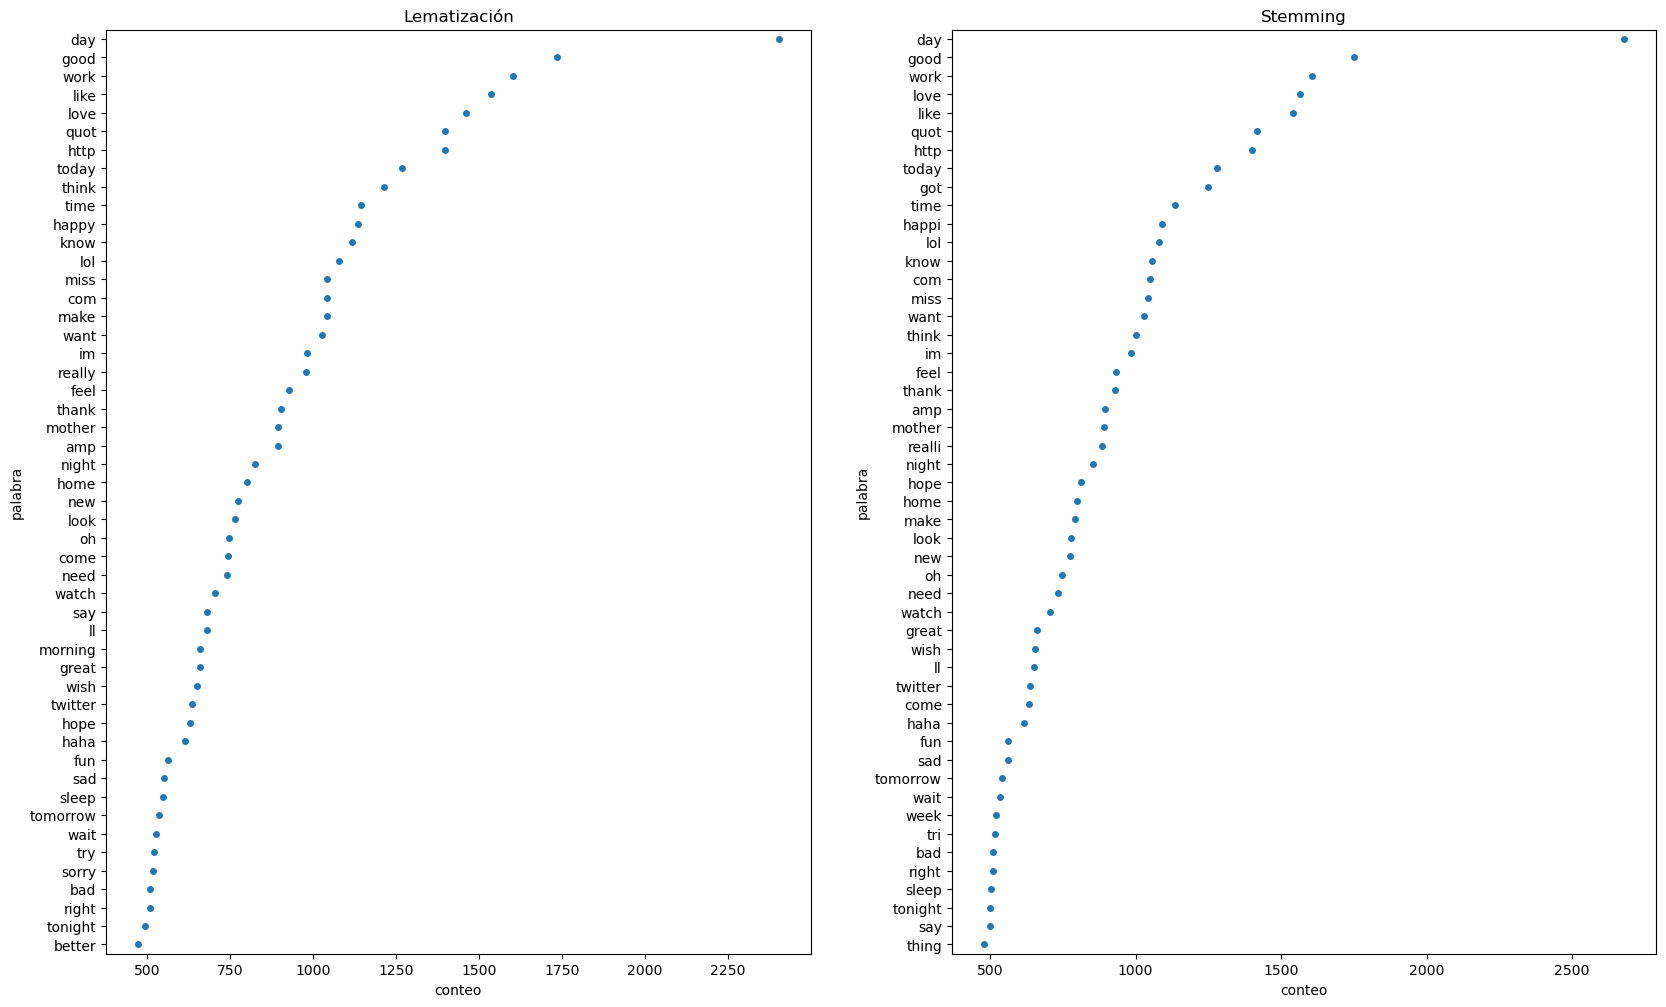

La cantidad de palabras distintas en la lematizacion fue: 37681
La cantidad de palabras distintas en el stemming fue: 37497


In [17]:
figure, axis = plt.subplots(1, 2, figsize=(20, 12))

sns.stripplot(data=df_lema.head(50), x="conteo", y="palabra", ax=axis[0])
sns.stripplot(data=df_stem.head(50), x="conteo", y="palabra", ax=axis[1])
axis[0].set_title("Lematización")
axis[1].set_title("Stemming")
plt.show()


print(f"La cantidad de palabras distintas en la lematizacion fue: {df_lema.shape[0]}")
print(f"La cantidad de palabras distintas en el stemming fue: {df_stem.shape[0]}")

- La lematización y el stemming presentaron un patrón de palabras bastante similares entre sí.

- La lematización presentó 37681 palabras distintas, mientras el stemming presentó 37497 palabras
distintas. Si nos basamos en este parámetro, el stemming es la mejor táctica para preprocesar el texto
y utilizarlo en un modelo de Machine Learning. Esto, ya que el modelo será más parsimonioso.

- La representación de las palabras con la lematización es más fiel al lenguaje que el stemming.
Ejemplos de este fenómeno ocurre con las siguientes palabras:

|Lematización|Stemming|
|-----------|--------|
happy|happi|
really|realli|

Teniendo en cuenta todos los resultados previos, **se utilizará la técnica de lematización para la
confección de cada modelo**. Esto, porque tiene una mejor interpretación de los datos, a pesar de
ser más costoso computacionalmente.

# Filtracion de palabras poco frecuentes

- Como se menciono en el enunciado, se filtraran todas las palabras que tengan una frecuencia menor
al 0.04% de la cantidad de textos en el dataset.

In [18]:
largo_df = df.shape[0]
filtro_frecuencias = int(round(largo_df * 0.0004, 0))


In [19]:
palabras_a_filtrar = df_lema.query("conteo < @filtro_frecuencias")
palabras_restantes = df_lema.query("conteo >= @filtro_frecuencias")
cambio_en_palabras = df_lema.shape[0] - palabras_a_filtrar.shape[0]
LISTA_PALABRAS_A_DEJAR = set(palabras_restantes.palabra.to_list())

print(f"Las palabras a filtrar son:\n{palabras_a_filtrar}\n")
print(f"Se pasara de {df_lema.shape[0]} a {cambio_en_palabras} palabras")

Las palabras a filtrar son:
            palabra  conteo
2006             ½ï      11
2007             dh      11
2008             pa      11
2009           melt      11
2010         centre      11
...             ...     ...
37676    hysterical       1
37677     hypocrite       1
37678  hypnoticzexy       1
37679      hypnosis       1
37680     lilmickee       1

[35675 rows x 2 columns]

Se pasara de 37681 a 2006 palabras


- Por lo tanto, se puede ver una disminucion considerable en la cantidad de palabras a analizar
en cada modelo predictivo. Se espera una disminucion importante en el costo computacional.

- El filtro de palabras se aplicara en el objeto CountVectorizer con el parametro vocabulary.

# Implementacion de modelos

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [27]:
grilla_logistic = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear", "sag", "saga"],
}

grilla_arbol_clasificacion = {
    "max_depth": range(3, 11),
    "max_leaf_nodes": range(1, 6),
    "criterion": ["gini", "entropy"],
}

grilla_random_forest = {
    "max_depth": range(5, 11),
    "n_estimators": range(500, 1001, 100),
    "max_features": ["sqrt", "log2"],
}

grilla_svm = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": [1, 0.1, 0.01, 0.001],
}

grilla_naive_bayes = {"alpha": [0.01, 0.1, 1, 10], "fit_prior": [True, False]}

modelo_logistic = GridSearchCV(
    LogisticRegression(),
    grilla_logistic,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_arbol = GridSearchCV(
    DecisionTreeClassifier(),
    grilla_arbol_clasificacion,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_random_forest = GridSearchCV(
    RandomForestClassifier(),
    grilla_random_forest,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_svm = GridSearchCV(
    SVC(),
    grilla_svm,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_naive_bayes = GridSearchCV(
    MultinomialNB(),
    grilla_naive_bayes,
    cv=5,
    scoring="accuracy",
    verbose=5,
)


# Division de Muestra

- A modo de demostracion de desempeno, se realizara un modelo con todas las palabras, y otro con
las palabras filtradas por frecuencia. Este analisis solamente se realizara con el modelo de
regresion logistica, ya que es menos costoso computacionalmente.

## Datos Filtrados por frecuencia

In [28]:
X = CountVectorizer(stop_words="english", vocabulary=LISTA_PALABRAS_A_DEJAR).fit_transform(
    df["procesados_lema"]
)
y = aux.codificar_sentimientos(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.335, random_state=1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ............C=0.0001, solver=lbfgs;, score=0.562 total time=   0.0s
[CV 2/5] END ............C=0.0001, solver=lbfgs;, score=0.574 total time=   0.0s
[CV 3/5] END ............C=0.0001, solver=lbfgs;, score=0.573 total time=   0.0s
[CV 4/5] END ............C=0.0001, solver=lbfgs;, score=0.562 total time=   0.0s
[CV 5/5] END ............C=0.0001, solver=lbfgs;, score=0.564 total time=   0.0s
[CV 1/5] END ........C=0.0001, solver=liblinear;, score=0.625 total time=   0.0s
[CV 2/5] END ........C=0.0001, solver=liblinear;, score=0.630 total time=   0.0s
[CV 3/5] END ........C=0.0001, solver=liblinear;, score=0.613 total time=   0.0s
[CV 4/5] END ........C=0.0001, solver=liblinear;, score=0.611 total time=   0.0s
[CV 5/5] END ........C=0.0001, solver=liblinear;, score=0.625 total time=   0.0s
[CV 1/5] END ..............C=0.0001, solver=sag;, score=0.562 total time=   0.0s
[CV 2/5] END ..............C=0.0001, solver=sag

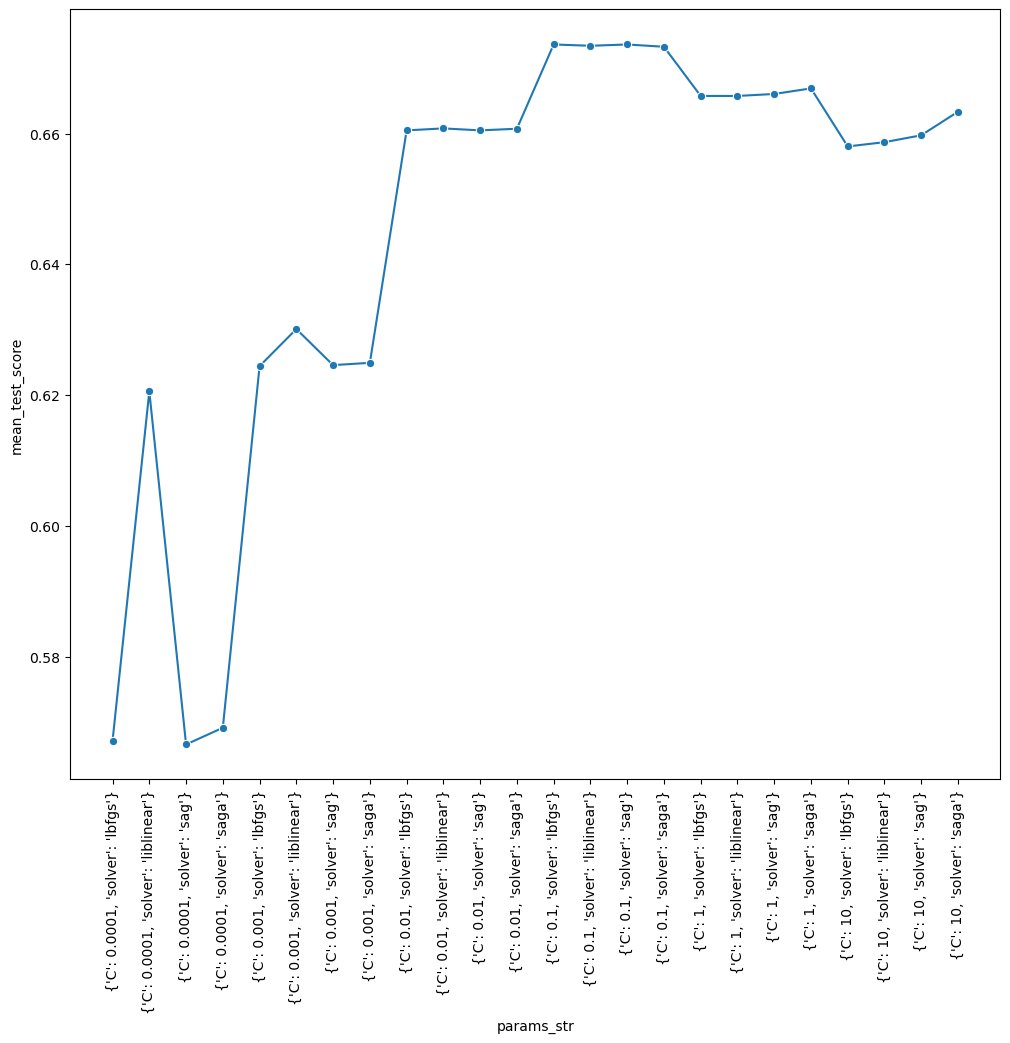

Los mejores parametros fueron: {'C': 0.1, 'solver': 'lbfgs'}
El mejor desempeno fue: 0.6736340852130326


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      5175
           1       0.68      0.61      0.64      4875

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6670903010033444
---------------------------------------------------------------------


In [29]:
modelo_logistic, resultados_logistic = aux.entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_logistic, X_train, X_test, y_train, y_test
)

## Datos sin filtro por frecuencia

In [30]:
X_c = CountVectorizer(stop_words="english").fit_transform(df["procesados_lema"])
y_c = aux.codificar_sentimientos(df["sentiment"])

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c, y_c, test_size=0.335, random_state=1
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ............C=0.0001, solver=lbfgs;, score=0.560 total time=   0.0s
[CV 2/5] END ............C=0.0001, solver=lbfgs;, score=0.567 total time=   0.0s
[CV 3/5] END ............C=0.0001, solver=lbfgs;, score=0.562 total time=   0.1s
[CV 4/5] END ............C=0.0001, solver=lbfgs;, score=0.555 total time=   0.0s
[CV 5/5] END ............C=0.0001, solver=lbfgs;, score=0.558 total time=   0.0s
[CV 1/5] END ........C=0.0001, solver=liblinear;, score=0.627 total time=   0.0s
[CV 2/5] END ........C=0.0001, solver=liblinear;, score=0.629 total time=   0.0s
[CV 3/5] END ........C=0.0001, solver=liblinear;, score=0.611 total time=   0.0s
[CV 4/5] END ........C=0.0001, solver=liblinear;, score=0.613 total time=   0.0s
[CV 5/5] END ........C=0.0001, solver=liblinear;, score=0.623 total time=   0.0s
[CV 1/5] END ..............C=0.0001, solver=sag;, score=0.561 total time=   0.0s
[CV 2/5] END ..............C=0.0001, solver=sag

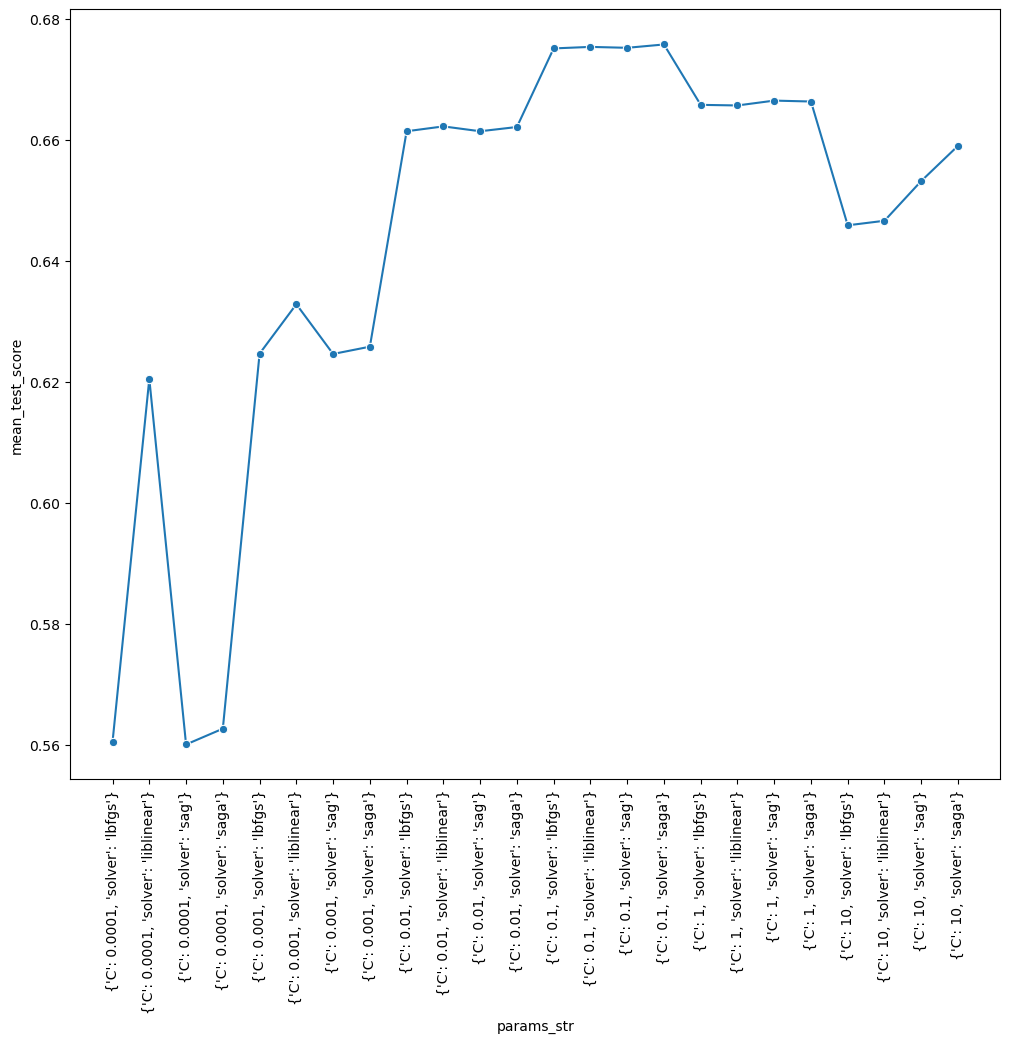

Los mejores parametros fueron: {'C': 0.1, 'solver': 'saga'}
El mejor desempeno fue: 0.6757393483709274


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      5180
           1       0.68      0.62      0.65      4870

    accuracy                           0.68     10050
   macro avg       0.68      0.67      0.67     10050
weighted avg       0.68      0.68      0.67     10050

El ROC fue de: 0.6742262135999302
---------------------------------------------------------------------


In [31]:
modelo_logistic, resultados_logistic = aux.entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_logistic, X_c_train, X_c_test, y_c_train, y_c_test
)

# Resumen

En la siguiente tabla se puede observar la diferencia en desempeno entre el modelo con las palabras
filtradas por frecuencia y el que carece de tal filtro:

|Metrica|Modelo Con Filtro|Modelo Sin Filtro|
|-------|-----------------|-----------------|
Mejor Accuracy en Entrenamiento|0.67|0.67|
Mejor Accuracy en Validacion|0.67|0.67|
ROC en Validacion|0.67|0.67|

Se observa que tanto el modelo filtrado, como el modelo sin filtro presentan resultados identicos 
(metricas redondeadas a 2 cifras decimales). Esta tendencia se observa tanto en el conjunto de datos
de entrenamiento, como en el conjunto de datos de validacion.

Por lo tanto, **se utilizara el modelo con el filtro de palabras, ya que reduce considerablemente
el costo computacional, y es mucho mas parsimonioso**.